#### Install and import Python libraries

In [1]:
import os
import sys


import matplotlib.pyplot as plt
import numpy as np
import time
import gif
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader
import os.path as osp
import motmetrics as mm
mm.lap.default_solver = 'lap'

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
root_dir = ".."
sys.path.append(os.path.join(root_dir, "src"))

from mot.data.data_track import MOT16Sequences
from mot.tracker.advanced import MPNTracker
from mot.eval import evaluate_mot_accums, get_mot_accum
from mot.models.gnn import SimilarityNet
from mot.visualize import plot_sequence, collect_frames_for_gif



## Configuration

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = "cpu"


# Multi-object tracking

## Configuration

In [4]:
seed = 12345
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True


## load pretrained

In [5]:
# Define our model, and init
similarity_net = SimilarityNet(
    node_dim=32,
    edge_dim=64,
    reid_dim=512,
    edges_in_dim=6,
    num_steps=10,
).to(device)


In [6]:
best_ckpt = torch.load(
    osp.join(root_dir, "models", "best_mpn_ckpt.pth"),
    map_location=lambda storage, loc: storage,
)
similarity_net.load_state_dict(best_ckpt)
MAX_PATIENCE = 20

tracker = MPNTracker(
    similarity_net=similarity_net.eval(),
    obj_detect=None,
    reid_model=None,
    patience=MAX_PATIENCE,
)


# Val seq


In [7]:

val_sequences = MOT16Sequences(
    "MOT16-val2", osp.join(root_dir, "data/MOT16"), vis_threshold=0.0
)
train_db = torch.load(
    osp.join(root_dir, "data/preprocessed_data/preprocessed_data_train_2.pth")
)
database = train_db

In [8]:
output_dir = None
#####

time_total = 0
mot_accums = []
results_seq = {}
for seq in val_sequences:
    # break
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    # data_loader = DataLoader(seq, batch_size=1, shuffle=False)
    with torch.no_grad():
        # for i, frame in enumerate(tqdm(data_loader)):
        for frame in database[str(seq)]:
            tracker.step(frame)

    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print("No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
        seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(
        mot_accums,
        [str(s) for s in val_sequences if not s.no_gt],
        generate_overall=True,
    )


Tracking: MOT16-02
Tracks found: 105
Runtime for MOT16-02: 3.6 s.
Tracking: MOT16-11
Tracks found: 86
Runtime for MOT16-11: 4.7 s.
Runtime for all sequences: 8.3 s.
          IDF1   IDP   IDR  Rcll  Prcn  GT MT PT ML  FP    FN IDs   FM  MOTA  MOTP IDt IDa IDm
MOT16-02 47.6% 67.7% 36.8% 52.2% 96.1%  62 11 38 13 390  8873 102  222 49.6% 0.096  59  49  10
MOT16-11 69.1% 76.1% 63.2% 80.2% 96.6%  75 44 24  7 266  1871  40   90 76.9% 0.083  31  16  12
OVERALL  55.7% 71.4% 45.7% 61.7% 96.3% 137 55 62 20 656 10744 142  312 58.8% 0.090  90  65  22


# Test set

In [9]:

val_sequences = MOT16Sequences(
    "MOT16-test", osp.join(root_dir, "data/MOT16"), vis_threshold=0.0
)

test_db = torch.load(
    osp.join(root_dir, "data/preprocessed_data/preprocessed_data_test_2.pth")
)
database = test_db

In [10]:
output_dir = None
#####

time_total = 0
mot_accums = []
results_seq = {}
for seq in val_sequences:
    # break
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    # data_loader = DataLoader(seq, batch_size=1, shuffle=False)
    with torch.no_grad():
        # for i, frame in enumerate(tqdm(data_loader)):
        for frame in database[str(seq)]:
            tracker.step(frame)

    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print("No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
        seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(
        mot_accums,
        [str(s) for s in val_sequences if not s.no_gt],
        generate_overall=True,
    )


Tracking: MOT16-01
No GT evaluation data available.
Tracks found: 79
Runtime for MOT16-01: 2.2 s.
Tracking: MOT16-08
No GT evaluation data available.
Tracks found: 128
Runtime for MOT16-08: 3.1 s.
Tracking: MOT16-12
No GT evaluation data available.
Tracks found: 133
Runtime for MOT16-12: 4.3 s.
Runtime for all sequences: 9.7 s.


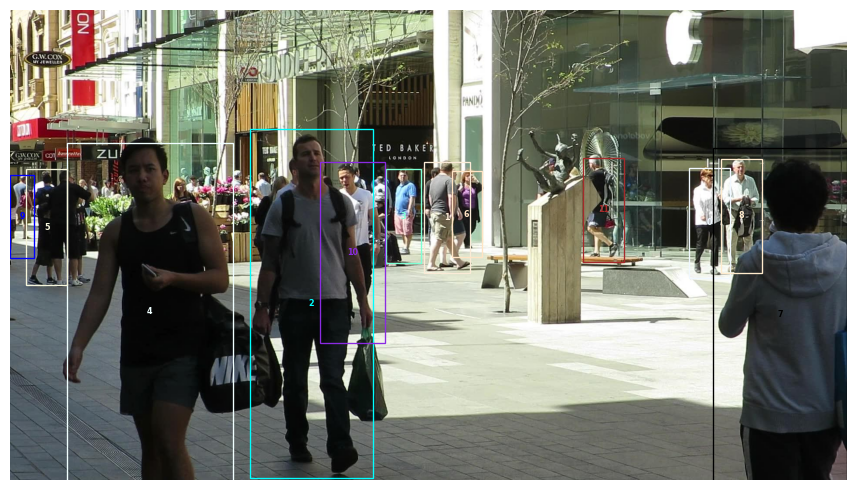

In [11]:
seq_name = "MOT16-08" #"MOT16-11"
plot_sequence(
    results_seq[seq_name],
    [s for s in val_sequences if str(s) == seq_name][0],
    first_n_frames=1,
)


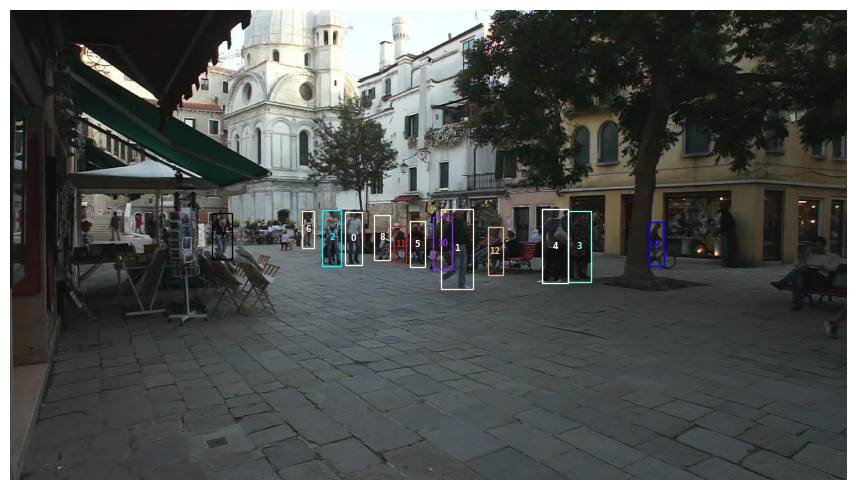

In [12]:
seq_name = "MOT16-01" #"MOT16-11"
plot_sequence(
    results_seq[seq_name],
    [s for s in val_sequences if str(s) == seq_name][0],
    first_n_frames=1,
)


# create gif

In [13]:
gif.options.matplotlib["dpi"] = 70
gif.options.matplotlib["bbox_inches"] = 'tight'
gif.options.matplotlib["pad_inches"] = 0.0


In [14]:
seq_name =  "MOT16-08" # "MOT16-12""MOT16-01" "MOT16-11"
sequence = [s for s in val_sequences if str(s) == seq_name][0]
tracker_seq_res = results_seq[seq_name]


In [15]:
frames = collect_frames_for_gif(sequence, tracker_seq_res)

  0%|          | 0/625 [00:00<?, ?it/s]

In [ ]:
dst_path_gif = os.path.join(root_dir, f"output/figs/{seq_name}-result.gif")
gif.save(frames, dst_path_gif, duration=50)
